In [1]:
import warnings
from typing import Callable, List, Optional, Sequence, Tuple, Union

import torch
import torchvision
from torch import Tensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.autograd as autograd
import math
from scipy.stats import ortho_group
from math import sin
from scipy.stats import special_ortho_group

In [2]:
# define new layer inheriting nn.Module
class NormalizedLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)

    def forward(self, input: Tensor) -> Tensor:
        x = super().forward(input)
        x *= (1 / (x.size(1) ** 0.5))
        return x  

In [3]:
class MLP(torch.nn.Module):

    def __init__(
        self,
        in_channels: int,
        hidden_channels: List[int],
        norm_layer: Optional[Callable[..., torch.nn.Module]] = None,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        inplace: Optional[bool] = None,
        bias: bool = True,
        dropout: float = 0.0,
        gamma: float = 1.0,
    ):
        super(MLP, self).__init__()
        params = {} if inplace is None else {"inplace": inplace}
        self.gamma = 1 # math.sqrt(in_channels)

        layers = []
        in_dim = in_channels
        for hidden_dim in hidden_channels[:-1]:
            layers.append(NormalizedLinear(in_dim, hidden_dim, bias=bias))

            if norm_layer is not None:
                layers.append(norm_layer(hidden_dim))
            layers.append(activation_layer())
            #layers.append(torch.nn.Dropout(dropout, **params))
            in_dim = hidden_dim

        layers.append(torch.nn.Linear(hidden_channels[-2], hidden_channels[-1], bias=bias))
        #layers.append(torch.nn.Dropout(dropout, **params))

        # self.model = nn.Sequential(*layers)
        self.layers = nn.Sequential(*layers)

    def init_weights(self) -> None:
         for layer in self.layers:
             if isinstance(layer, torch.nn.Linear):
                #make the initialization of weights from a normal distribution
                torch.nn.init.xavier_normal_(layer.weight.data)
                #torch.nn.init.kaiming_normal_(layer.weight.data)
                # multiply by 100
                #layer.weight.data *= 10.0
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias.data)

    #Alternative definition of forward
    def forward(self, x):
        x = self.layers.forward(x)
        x = (1 / self.gamma) * x
        return x   

    # create a forward functions that stops before the last layer is applied
    def forward_partial(self, x):
        #forward but stop before the last layer is applied
        for layer in self.layers[:-1]:
            x = layer(x)
        return x

    def forward_partial2(self, x):
        for layer in self.layers[:-3]:
            x = layer(x)
        return x

    def forward_partial3(self, x):
        for layer in self.layers[:-5]:
            x = layer(x)
        return x

In [4]:
# define a gram matrix function to compute the gram matrix using the forward_partial function
def gram_matrix(x, model):
    # get the output of the model before the last layer
    x1 = model.forward_partial(x)
    x2 = model.forward_partial2(x)
    x3 = model.forward_partial3(x)
    # compute the gram matrix
    print(x.shape)
    gram1 = (1 / x1.shape[1]) * torch.matmul(x1, x1.T)
    gram2 = (1 / x2.shape[1]) * torch.matmul(x2, x2.T)
    gram3 = (1 / x3.shape[1]) * torch.matmul(x3, x3.T)
    return gram1, gram2, gram3

In [5]:
# load mnsit data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2**10, shuffle=True, num_workers=0)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2**10, shuffle=False, num_workers=0)

trainset1 = trainset
testset1 = testset

trainset_partial = trainset.data[:10000]
trainset_partial = trainset_partial.reshape(-1, 28*28)
train_targets_partial = trainset.targets[:10000]
testset_partial = testset.data[:5000]
testset_partial = testset_partial.reshape(-1, 28*28)
test_targets_partial = testset.targets[:5000]

trainloader_partial = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(trainset_partial.float(), train_targets_partial), batch_size=2**10, shuffle=True, num_workers=0)
testloader_partial = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(testset_partial.float(), test_targets_partial), batch_size=2**10, shuffle=False, num_workers=0)

# get data
dataiter = iter(trainloader)
images, labels = next(dataiter)

testiter = iter(testloader)
test_images, test_labels = next(testiter)

images = images.reshape(-1, 28 * 28)
test_images = test_images.reshape(-1, 28 * 28)
trainset = trainset.data.reshape(-1, 28 * 28)
testset = testset.data.reshape(-1, 28 * 28)

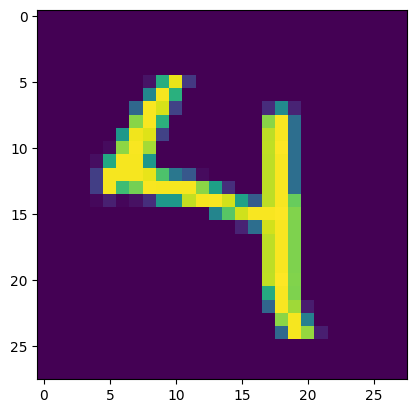

In [6]:
# print one train example
plt.imshow(images[7].reshape(28, 28))
plt.show()

In [7]:
# initialize model

torch.manual_seed(444)
model = MLP(28 * 28, [2048, 1024, 512, 256, 10])
model.init_weights()

model1 = MLP(28 * 28, [2048, 1024, 512, 256, 10])
model1.init_weights()

In [8]:
def train_mnist(trainloader, testloader, model, lr=1e-2, epochs = 10):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    test_loss_history = []

    for epoch in range(epochs):
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1)  # this reshapes the images to [batch_size, 784]

            optimizer.zero_grad()

            y_pred = model.forward(images)

            loss = loss_fn(y_pred, labels)
            loss_history.append(loss.item())

            loss.backward()
            optimizer.step()

            # get test pred and loss
            # with torch.no_grad():
            #     for test_images, test_labels in testloader:
            #         test_images = test_images.view(test_images.shape[0], -1) 
            #         test_pred = model.forward(test_images)
            #         test_loss = loss_fn(test_pred, test_labels)
            #         test_loss_history.append(test_loss.item())

            # test train loss on one batch
            with torch.no_grad():
                images, labels = next(iter(testloader))
                images = images.view(images.shape[0], -1) 
                test_pred = model.forward(images)
                test_loss = loss_fn(test_pred, labels)
                test_loss_history.append(test_loss.item())

        print(f"epoch {epoch}, loss: ", loss.item())
        print(f"epoch {epoch}, test loss: ", test_loss.item())

    return loss_history, test_loss_history

torch.Size([1024, 784])


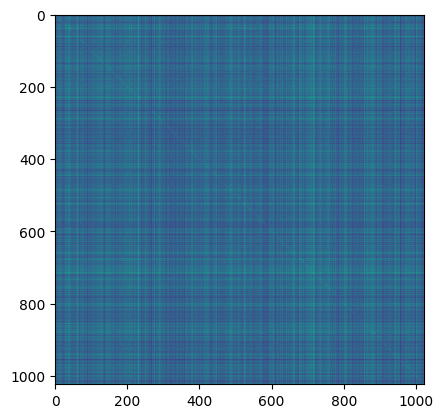

In [9]:
# get gram matrix of mnist data
gram1, gram2, gram3 = gram_matrix(images, model)

# plot gram matrix
plt.imshow(gram1.detach().numpy())

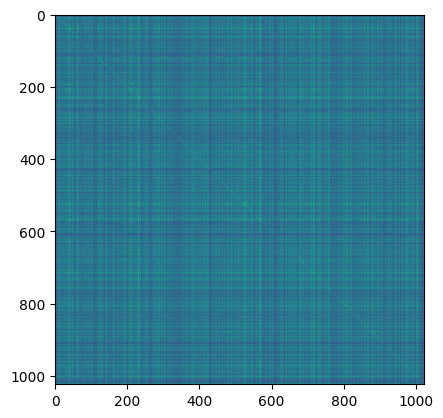

In [10]:
plt.imshow(gram2.detach().numpy())

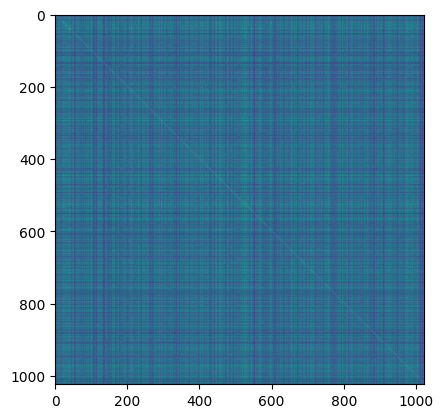

In [11]:
plt.imshow(gram3.detach().numpy())

In [12]:
loss_history, test_loss_history = train_mnist(trainloader, testloader, model, lr=1e-2, epochs=10)

epoch 0, loss:  1.542683482170105
epoch 0, test loss:  1.5464599132537842
epoch 1, loss:  0.5446320176124573
epoch 1, test loss:  0.5130828619003296
epoch 2, loss:  0.36219286918640137
epoch 2, test loss:  0.2787032127380371
epoch 3, loss:  0.22533564269542694
epoch 3, test loss:  0.20767313241958618
epoch 4, loss:  0.1585284173488617
epoch 4, test loss:  0.16505272686481476
epoch 5, loss:  0.10010117292404175
epoch 5, test loss:  0.11908157914876938
epoch 6, loss:  0.12240901589393616
epoch 6, test loss:  0.12656250596046448
epoch 7, loss:  0.09235721826553345
epoch 7, test loss:  0.11497535556554794
epoch 8, loss:  0.06768091022968292
epoch 8, test loss:  0.09380630403757095
epoch 9, loss:  0.057726044207811356
epoch 9, test loss:  0.08706357330083847


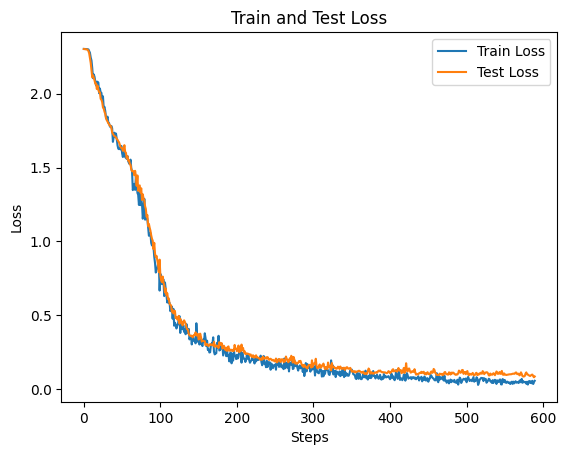

In [13]:
# plot loss and test loss
plt.plot(loss_history)
plt.plot(test_loss_history)
plt.title("Train and Test Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])
plt.show()

In [14]:
# define function to test accuracy
def test_mnist(x, y, model):
    y_pred = model.forward(x)
    accuracy = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
    return accuracy

In [15]:
def compute_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [16]:
model.eval()  # Set the model to evaluation mode
accuracy = compute_accuracy(model, trainloader)
print(f"Accuracy on train data: {accuracy}%")
accuracy = compute_accuracy(model, testloader)
print(f"Accuracy on test data: {accuracy}%")

Accuracy on train data: 98.76833333333333%
Accuracy on test data: 97.25%


torch.Size([1024, 784])


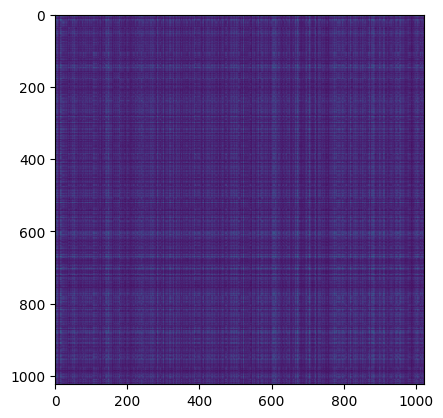

In [17]:
# get gram matrices after training
gram_after1, gram_after2, gram_after3 = gram_matrix(images, model)

# plot gram matrix
plt.imshow(gram_after1.detach().numpy())

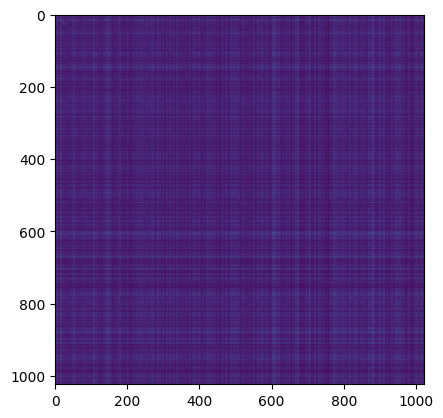

In [18]:
plt.imshow(gram_after2.detach().numpy())

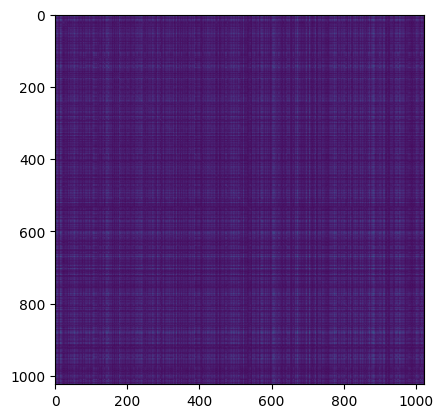

In [19]:
plt.imshow(gram_after3.detach().numpy())

In [20]:
model2 = MLP(28 * 28, [2048, 1024, 512, 256, 10])
model2.init_weights()

model3 = MLP(28 * 28, [2048, 1024, 512, 256, 10])
model3.init_weights()


In [21]:

rotation_matrix = special_ortho_group.rvs(dim=784)
#convert to tensor
rotation_matrix = torch.tensor(rotation_matrix, dtype=torch.float32)
trainset1_data = trainset1.data.reshape(-1, 28*28)
testset1_data = testset1.data.reshape(-1, 28*28)
trainset_partial_data = trainset_partial.data.reshape(-1, 28*28)
testset_partial_data = testset_partial.data.reshape(-1, 28*28)

In [22]:
# rotate datasets
rot_trainset1_data = torch.matmul(trainset1_data.float(), rotation_matrix.float())
rot_testset1_data = torch.matmul(testset1_data.float(), rotation_matrix.float())

#create trainloader and testloader
rot_trainloader1 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(trainset1_data.float(), trainset1.targets), batch_size=2**10, shuffle=True, num_workers=0)
rot_testloader1 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(testset1_data.float(), testset1.targets), batch_size=2**10, shuffle=False, num_workers=0)

In [23]:
loss_history1, test_loss_history1 = train_mnist(rot_trainloader1, rot_testloader1, model2, lr=1e-2, epochs=10)

epoch 0, loss:  0.26156240701675415
epoch 0, test loss:  0.23393842577934265
epoch 1, loss:  0.12977777421474457
epoch 1, test loss:  0.12640440464019775
epoch 2, loss:  0.074556365609169
epoch 2, test loss:  0.09943925589323044
epoch 3, loss:  0.0625646561384201
epoch 3, test loss:  0.09057886153459549
epoch 4, loss:  0.05447506904602051
epoch 4, test loss:  0.09100986272096634
epoch 5, loss:  0.04314068332314491
epoch 5, test loss:  0.06521875411272049
epoch 6, loss:  0.015192098915576935
epoch 6, test loss:  0.09901506453752518
epoch 7, loss:  0.038167547434568405
epoch 7, test loss:  0.08883564174175262
epoch 8, loss:  0.01728075183928013
epoch 8, test loss:  0.12347245216369629
epoch 9, loss:  0.012939359061419964
epoch 9, test loss:  0.10535065829753876


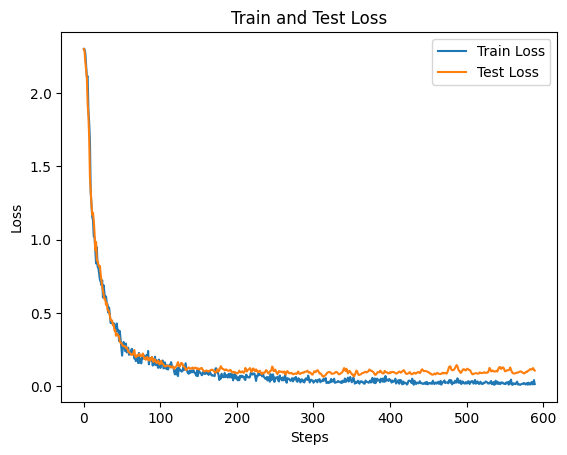

In [24]:
# plot loss and test loss
plt.plot(loss_history1)
plt.plot(test_loss_history1)
plt.title("Train and Test Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])
plt.show()

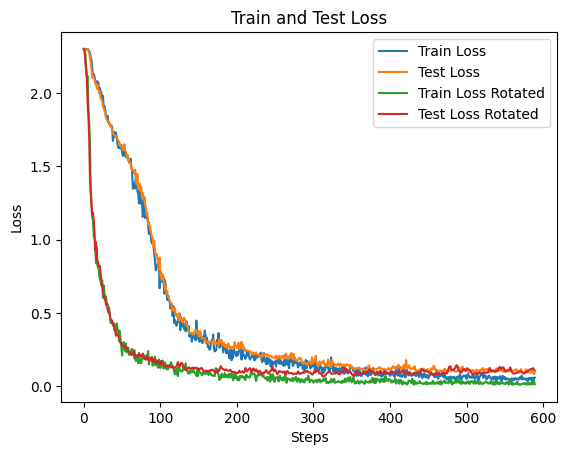

In [26]:
# plot loss and test loss and loss1 and test loss1
plt.plot(loss_history)
plt.plot(test_loss_history)
plt.plot(loss_history1)
plt.plot(test_loss_history1)
plt.title("Train and Test Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss", "Train Loss Rotated", "Test Loss Rotated"])
plt.show()

In [25]:
model2.eval()  # Set the model to evaluation mode
accuracy = compute_accuracy(model2, rot_trainloader1)
print(f"Accuracy on rotated train data: {accuracy}%")
accuracy = compute_accuracy(model2, rot_testloader1)
print(f"Accuracy on rotated test data: {accuracy}%")

Accuracy on rotated train data: 99.66%
Accuracy on rotated test data: 98.04%
